# NYPD_Allegations_mapped

## Datasets
### - [Police precincts mapped](https://data.cityofnewyork.us/Public-Safety/Police-Precincts/78dh-3ptz)
### - [NYC stop and Frisk 2018 Dataset](https://www1.nyc.gov/site/nypd/stats/reports-analysis/stopfrisk.page)

This script maps the total number of allegations made against police officers since these records began. It will map the total number of allegations to precincts across New York City.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import geopandas as geopandas
import geoplot as gplt
from geopandas import GeoDataFrame
from mpl_toolkits.axes_grid1 import make_axes_locatable
import missingno as msn #helps with missing data in geo data sets 

In [3]:
nypd_allegations = pd.read_csv("/Users/jordan/Documents/GitHub/NYPD_allegations/allegations.csv")

#A snapshot of the data.
nypd_allegations.head(3)

,unique_mos_id,first_name,last_name,command_now,complaint_id,month_received,year_received,month_closed,year_closed,command_at_incident,...,mos_age_incident,complainant_ethnicity,complainant_gender,complainant_age_incident,fado_type,allegation,precinct,contact_reason,outcome_description,board_disposition
0,10004,Jonathan,Ruiz,078 PCT,42835,7,2019,5,2020,078 PCT,...,32,Black,Female,38.0,Abuse of Authority,Failure to provide RTKA card,78.0,Report-domestic dispute,No arrest made or summons issued,Substantiated (Command Lvl Instructions)
1,10007,John,Sears,078 PCT,24601,11,2011,8,2012,PBBS,...,24,Black,Male,26.0,Discourtesy,Action,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges)
2,10007,John,Sears,078 PCT,24601,11,2011,8,2012,PBBS,...,24,Black,Male,26.0,Offensive Language,Race,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges)


In [5]:
#New file Geo coordinates for police precincts - taken from NYC open data
police_pre = geopandas.read_file("/Users/jordan/Documents/GitHub/2018NycStopAndFrisk/NYC_Police_Precincts/NYC_Police_Precincts.geojson")

In [6]:
#Check the first 5 rows for what data is contained
police_pre.head(3)

,OBJECTID,Precinct,SHAPE_Length,SHAPE_Area,geometry
0,1,1,0.259319,0.000468,"MULTIPOLYGON (((-74.04388 40.69020, -74.04351 ..."
1,2,5,0.058732,0.000179,"MULTIPOLYGON (((-73.98864 40.72294, -73.98869 ..."
2,3,6,0.087053,0.000219,"MULTIPOLYGON (((-73.99969 40.73856, -73.99684 ..."


In [7]:
#check rename of column geometry
police_pre = geopandas.GeoDataFrame(police_pre, geometry='geometry')

In [8]:
#Check datatype of police_pre
type(police_pre)

geopandas.geodataframe.GeoDataFrame

In [9]:
#Check the type of geometry column 
type(police_pre['geometry'])

geopandas.geoseries.GeoSeries

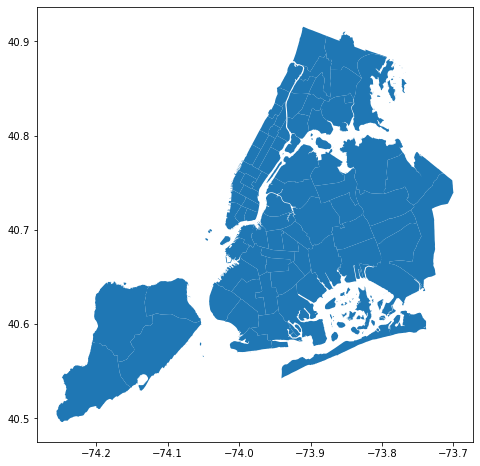

In [10]:
#plot the police precincts - check this file works and are accurate
police_pre.plot(figsize=(12,8));


In [11]:
#Isolate precinct and total counts and instances - Group by function for which precincts - 
#these will be joined to the geojson file

allegation_count = nypd_allegations.value_counts(subset=['precinct']).rename_axis('Precinct').reset_index(name='counts')
print (allegation_count)

    Precinct  counts
0       75.0    2172
1       73.0    1163
2       44.0    1139
3       46.0    1120
4       67.0    1119
..       ...     ...
74      17.0      76
75     111.0      37
76       0.0      21
77      22.0      12
78    1000.0       3

[79 rows x 2 columns]


In [13]:
#Combine data based off precinct names 
fulldata = allegation_count.merge(police_pre, left_on=['Precinct'], right_on=['Precinct'])
fulldata.head(2)

,Precinct,counts,OBJECTID,SHAPE_Length,SHAPE_Area,geometry
0,75.0,2172,47,0.328220,0.001785,"MULTIPOLYGON (((-73.85023 40.62333, -73.85024 ..."
1,73.0,1163,46,0.099876,0.000512,"MULTIPOLYGON (((-73.90405 40.67923, -73.90334 ..."


In [14]:
#Drop unnecessary columns from dataset 
fulldata = fulldata.drop(fulldata.columns[[2, 3, 4]], axis=1)

In [16]:
fulldata.head()

,Precinct,counts,geometry
0,75.0,2172,"MULTIPOLYGON (((-73.85023 40.62333, -73.85024 ..."
1,73.0,1163,"MULTIPOLYGON (((-73.90405 40.67923, -73.90334 ..."
2,44.0,1139,"MULTIPOLYGON (((-73.90270 40.84459, -73.90271 ..."
3,46.0,1120,"MULTIPOLYGON (((-73.89138 40.86171, -73.89142 ..."
4,67.0,1119,"MULTIPOLYGON (((-73.90755 40.65119, -73.90849 ..."


In [17]:
gdf = geopandas.GeoDataFrame(fulldata, crs="EPSG:4326")

In [18]:
gdf.head()

,Precinct,counts,geometry
0,75.0,2172,"MULTIPOLYGON (((-73.85023 40.62333, -73.85024 ..."
1,73.0,1163,"MULTIPOLYGON (((-73.90405 40.67923, -73.90334 ..."
2,44.0,1139,"MULTIPOLYGON (((-73.90270 40.84459, -73.90271 ..."
3,46.0,1120,"MULTIPOLYGON (((-73.89138 40.86171, -73.89142 ..."
4,67.0,1119,"MULTIPOLYGON (((-73.90755 40.65119, -73.90849 ..."


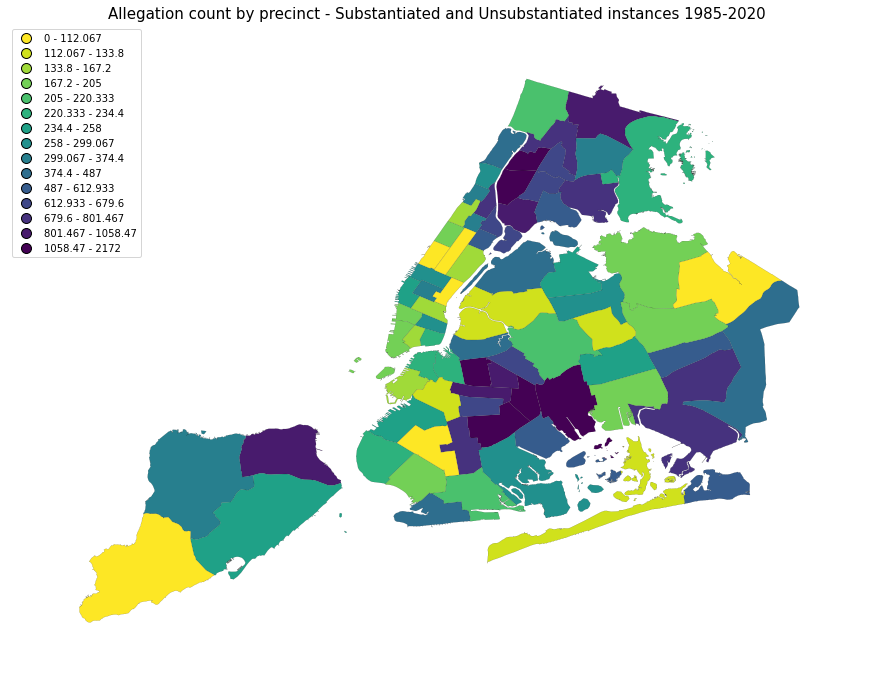

In [22]:
# Map
# Initialize the figure
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
# Set up the color sheme:
import mapclassify as mc
scheme = mc.Quantiles(gdf['counts'], k=15)
gplt.choropleth(gdf, 
    hue="counts", 
    linewidth=.1,
    scheme=scheme, cmap='viridis_r',
    legend=True,
    edgecolor='black',
    ax=ax);

ax.set_title('Allegation count by precinct - Substantiated and Unsubstantiated instances 1985-2020 ', fontsize=15);